# Surface Mass Balance 

Import relevant Libaries 

In [74]:
%pip install pyarrow
%pip install plotly
%pip update pandas

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [75]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

In [76]:
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set WD

In [77]:
import os

from pyrsistent import v
os.getcwd()
os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')


**Load New Promice Data**

In [78]:
#Function for loading data and converting to datetime 
def load_promice(path_to_file):
    '''
    Loading PROMICE data for a given path into a DataFrame.
    + adding time index
    
    INTPUTS:
        path_to_file: Path to the desired file containing PROMICE data [string]
    
    OUTPUTS:
        df: Dataframe containing PROMICE data for the desired settings [DataFrame]
    '''

    df = pd.read_parquet(path_to_file, engine='pyarrow')
    df['time'] = pd.to_datetime(df.time, utc=True)
    df = df.set_index('time')
    return df




In [79]:
df = load_promice('data/new_promice/all_promice_data_hourly.parquet.gzip')

**Helper functions**

In [80]:
#Function for writing to Markdown Report
def Msg(txt):
    f = open("out/Report.md", "a")
    print(txt)
    f.write(txt + "\n")

In [81]:
#For outlier detecttion and filter 
def hampel(vals_orig, k=7*24, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    outlier_idx[0:round(k/2)]=False
    vals.loc[outlier_idx]=np.nan
    return(vals)

In [ ]:
#What is this intended for?
df[['DepthPressureTransducer(m)',
       'DepthPressureTransducer_Cor(m)', 'DepthPressureTransducer_Cor_adj(m)',
    'depth_t_i_1',
 'depth_t_i_2',
 'depth_t_i_3',
 'depth_t_i_4',
 'depth_t_i_5',
 'depth_t_i_6',
 'depth_t_i_7',
 'depth_t_i_8',]].groupby(df.station_name).count()


In [27]:
# Old Data
#df = pd.read_parquet('data\promice_daily.gzip', engine='pyarrow')

In [ ]:
# Old Data
#df[['DepthPressureTransducer(m)',
#       'DepthPressureTransducer_Cor(m)']].groupby(df.file).count()

**Visual Exploration**

In [58]:
# Comment Nils: For some reason the data is not shown in all visuals? The loop is not working correct


In [8]:
for site in df.stid.unique().tolist():
    print(site)

CEN1
CEN2
CP1
DY2
EGP
HUM
JAR
JAR_O
KAN_B
KAN_L
KAN_M
KAN_U
KPC_Lv3
KPC_L
KPC_Uv3
KPC_U
LYN_L
LYN_T
MIT
NAE
NAU
NEM
NSE
NUK_K
NUK_L
NUK_N
NUK_Uv3
NUK_U
QAS_A
QAS_Lv3
QAS_L
QAS_M
QAS_Uv3
QAS_U
Roof_GEUS
Roof_PROMICE
SCO_L
SCO_U
SDL
SDM
SWC
SWC_O
TAS_A
TAS_L
TAS_U
THU_L2
THU_L
THU_U2
THU_U
TUN
UPE_L
UPE_U
UWN
WEG_B
ZAK_L
ZAK_Uv3
ZAK_U


**Identifying ablation periods**

In [82]:
#Formatting years and setting index for ablation window
years = df.index.year.unique().values
ind_start = years.copy()
ind_end =  years.copy()

In [83]:
#Calling hampel function
df["z_pt_cor_adj"] = hampel(df["z_pt_cor"].interpolate(limit=72)).values
df["z_surf_1_adj"] = hampel(df["z_surf_1"].interpolate(limit=72)).values
df["z_surf_2_adj"] = hampel(df["z_surf_2"].interpolate(limit=72)).values

In [86]:
df.index.is_monotonic
df.sort_index(inplace=True)
df.index.is_monotonic

True

In [87]:
#Setting ablation thresholds and defining period --> Doesn't work 
#df = df.sort_index() # Added as the series was not monotonic for some reason
#df = df.reindex(sorted(df.index))
smoothed_PT =  df['z_pt_cor'].interpolate(limit=72).rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
smoothed_PT = smoothed_PT.rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
threshold_ablation = -0.0002 # Modify value if needed
ind_ablation = np.logical_and(smoothed_PT.diff().values < threshold_ablation, 
                                  np.isin(smoothed_PT.diff().index.month, [6, 7, 8, 9]))
ind_ablation = np.concatenate((ind_ablation[4*24:], np.repeat(ind_ablation[-(4*24):-(4*24-1)], 4*24)))

In [88]:
#Finding ablation periods in years
for i, y in enumerate(years):
    #for each year
        ind_yr = df.index.year.values==y
        ind_abl_yr = np.logical_and(ind_yr, ind_ablation)
        if np.any(ind_abl_yr):
            # if there are some ablation flagged for that year
            # then find begining and end
            ind_start[i] = np.argwhere(ind_abl_yr)[0][0]
            ind_end[i] = np.argwhere(ind_abl_yr)[-1][0]
            
        else:
            # otherwise left as nan
            ind_start[i] = -999
            ind_end[i] = -999


In [94]:
#Printing one site 'KAN_L' to indentify ablation periods
def plotsite(df,site):
        df = df[df["stid"] ==  site]
        f1 = plt.figure(figsize=(10, 8))    
        df["z_pt_cor_adj"].plot(label = 'Pressure transducer')
        df["z_surf_1_adj"].plot(label = 'SonicRanger1')
        df["z_surf_2_adj"].plot(label = 'SonicRanger2')
        df["z_surf_combined"].plot(label = 'Summary',
                linestyle='--', linewidth=2, color = 'tab:red')

        plt.legend(prop={'size': 15})
        plt.xlabel('Year',size=20)
        plt.ylabel('Height (m)',size=20)
        plt.title(site,size=20)
        plt.grid()

        plt.legend(prop={'size': 15})
        plt.xlabel('Year',size=20)
        plt.ylabel('Height (m)',size=20)
        plt.title(site,size=20)
        plt.grid()

        # For orange coloring of ablation periods
        for i, y in enumerate(years):
                plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)
        
        # Add figure to /figures
        f1.savefig('figures/'+site+'_surface_height.png',dpi=90, bbox_inches='tight')
        Msg('[![Surface height adjustement at '+ site+']'+\
                '(../figures/'+site+'_surface_height.png)]'+\
                '(../figures/'+site+'_surface_height.png)')


TypeError: 'int' object is not iterable

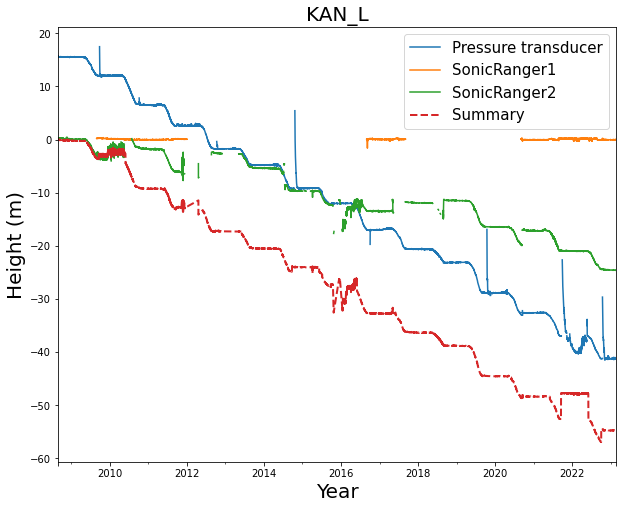

In [95]:
#Testing for KAN_L in specific period
df_abl = df['2017-01-05':'2017-08-30']
plotsite(df, 'KAN_L')

In [ ]:
# Takes some time - For all sites
for site in df.stid.unique().tolist():
    df = df[df["stid"] == site]
    f1 = plt.figure(figsize=(10, 8))    
    df["z_pt_cor_adj"].plot(label = 'Pressure transducer')
    df["z_surf_1_adj"].plot(label = 'SonicRanger1')
    df["z_surf_2_adj"].plot(label = 'SonicRanger2')
    df["z_surf_combined"].plot(label = 'Summary',
             linestyle='--', linewidth=2, color = 'tab:red')

    plt.legend(prop={'size': 15})
    plt.xlabel('Year',size=20)
    plt.ylabel('Height (m)',size=20)
    plt.title(site,size=20)
    plt.grid()
   # for i, y in enumerate(years):
   #     plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)

**PCA**

**Multivariate Regression**